# Weather Data

The Met Office provides sets of historical climate data, available [here](https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data).

This data is split by weather station. We can select a particular station, and download its data using the below code. Below, I make use of [`wget`](https://linux.die.net/man/1/wget) - a linux command line tool for downloading data from the web.

In [ ]:
ALL_STATION_CODES = {
  'Aberporth': 'aberporth',
  'Armagh': 'armagh',
  'Ballypatrick Forest': 'ballypatrick',
  'Bradford': 'bradford',
  'Braemar': 'braemar',
  'Camborne': 'camborne',
  'Cambridge NIAB': 'cambridge',
  'Cardiff Bute Park': 'cardiff',
  'Chivenor': 'chivenor',
  'Cwmystwyth': 'cwmystwyth',
  'Dunstaffnage': 'dunstaffnage',
  'Durham': 'durham',
  'Eastbourne': 'eastbourne',
  'Eskdalemuir': 'eskdalemuir',
  'Heathrow': 'heathrow',
  'Hurn': 'hurn',
  'Lerwick': 'larwick',
  'Leuchars': 'leuchars',
  'Lowestofta': 'lowestofta',
  'Manston': 'manston',
  'Nairn': 'narin',
  'Newton Rigg': 'newtonrigg',
  'Oxford': 'oxford',
  'Paisley': 'paisley',
  'Ringway': 'ringway',
  'Ross-on-Wye': 'rossonwye',
  'Shawbury': 'shawbury',
  'Sheffield': 'sheffield',
  'Southampton': 'southampton',
  'Stornoway Airport': 'stornoway',
  'Sutton Bonington': 'suttonbonington',
  'Tiree': 'tiree',
  'Valley': 'valley',
  'Waddington': 'waddington',
  'Whitby': 'whihtby',
  'Wick Airport': 'wickairport',
  'Yeovilton': 'yeovilton',
}

STATION = 'Paisley'
CODE = ALL_STATION_CODES[STATION]
URL = f'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/{CODE}data.txt'
TXT_FILE_NAME = f'{CODE}.txt'

# Putting an exclamation at the starts lets us run linux commands, instead of python.
!wget $URL -O $TXT_FILE_NAME

--2022-08-23 14:03:45--  https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/paisleydata.txt
Resolving www.metoffice.gov.uk (www.metoffice.gov.uk)... 104.127.164.124
Connecting to www.metoffice.gov.uk (www.metoffice.gov.uk)|104.127.164.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40339 (39K) [text/plain]
Saving to: ‘paisley.txt’

paisley.txt         100%[===================>]  39.39K  --.-KB/s    in 0.03s   

2022-08-23 14:03:45 (1.23 MB/s) - ‘paisley.txt’ saved [40339/40339]



Let's take a quick look at the data we downloaded. More linux commands, `head` shows the first 10 lines of a file, `tail` shows the last ten. `echo` just prints what we tell it to.

In [ ]:
!head $TXT_FILE_NAME
!echo ...
!tail $TXT_FILE_NAME

Paisley
Location 247800E 664200N, Lat 55.846 Lon -4.430, 32 metres amsl
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.
   yyyy  mm   tmax    tmin      af    rain     sun
              degC    degC    days      mm   hours
   1959   1    4.0    -2.0      25    40.9    54.1
   1959   2    6.6     2.1      10    41.8    17.8
   1959   3   10.6     4.2       0    50.9    85.7
...
   2021  10   13.9*    8.7*      0*  181.6*   67.8*
   2021  11   10.6*    4.9*      4*   72.4*   72.1*
   2021  12    7.4*    3.1*      3*   89.1*   14.7*
   2022   1    8.5*    4.3*      4*   75.9*   44.6*  Provisional
   2022   2    8.7*    3.4*      2*  208.8*   61.5*  Provisional
   2022   3   12.5*    2.9*      8*   38.5*  177.4*  Provisional
   2022   4   13.9*    5.1*      4*   39.5*  161.2*  Provisio

Here we can take a look at the format of the file. The file has some description at the top (first five lines) and then after this has 7 columns of data: first two being the date, second two being temperature, then air frost, rain, and finally hours of sunshine. This header is really across two rows, with the second being units. Although, some units are not specified so the second row doesn't match up with the first in terms of number of columns.

These columns of data have no *separator* (a character which marks the divide between columns, also called a delimiter) - this is unusual. In tabulated data we normally look for a separator like a comma, a space, or a tab.

The columns in this file are separated by **position**.

Also notable is the sudden appearance of the word "Provisional" in the final 7 rows in a column not previously present as well as the inclusion of an asterisk for the final rows of some columns.

**We need to consider all these things as we read the data into python.**

We can use a library called `pandas` to read this, using its `read_csv` function. Although we are not reading a "comma separated value" (CSV) file,  `pandas.read_csv` is flexible enough that it can read our file anyway.

In [ ]:
import pandas as pd
df = pd.read_csv(
    # The location of the file we want to read. In this case, our file location
    # is stored in a variable
    TXT_FILE_NAME,
    
    # The first five rows contain textual description, not tabulated data and
    # should be removed. The sixth row also needs to be removed...
    skiprows=[*range(5), 6],
    
    # The bottom 7 rows contain that odd extra 'Provisional' which throws a
    # spanner in the works when we want to parse it. Let's strip that data.
    skipfooter=7,
    
    # What delimiter to use? Remember that we normally look for a particular
    # character to use to split up the columns. Here, we have no such character.
    # What we do have are columns at particular positions *separated by blocks
    # of whitespace*. We can use something called a regex pattern to specify
    # a delimiter of several space characters strung together in a row.

    # Regex ("regular expressions") are notoriously quite tricky to work with,
    # but are extremely useful. We're not doing anything complicated with regex,
    # just selecting a couple spaces. This is achieved by selecting a space
    # character using '\s', and then saying we need one or more of them using '+'.
    delimiter=r'\s+',
    # For a great website on using regex I recommend checking out https://regexr.com/
    
    # This tells pandas to use the python parser instead of the c parser. Don't
    # worry about it - this line isn't strictly necessary but it silences warnings.
    engine='python',
    
    # By default, pandas will error out if it encounters a bad line. We don't
    # want that. This tells pandas to only issue a warning if a bad line is
    # found and to then continue parsing.
    on_bad_lines='warn'
  )

# Remove first data row (counting starts at zero) which is really the header units.
df.drop(index=0, inplace=True)

# Make sure the year and month are expressed as numbers (not text)
# df['yyyy'] = pd.to_numeric(df['yyyy'])
# df['mm'] = pd.to_numeric(df['mm'])

# get rid of those pesky asterisks on the values and ensure all values are
# correctly interpreted as numbers
def to_number(v):
  if isinstance(v, str):
    if v.endswith('*'):
      v = float(v[:-1])
    elif '.' in v:
      v = float(v)
    else:
      v = int(v)
  return v

for k in df.columns:
  df[k] = [to_number(t) for t in df[k]]

print(df)

     yyyy  mm  tmax  tmin    af   rain    sun
1    1959   2   6.6   2.1  10.0   41.8   17.8
2    1959   3  10.6   4.2   0.0   50.9   85.7
3    1959   4  13.0   5.2   0.0   76.3  125.1
4    1959   5  18.1   7.9   0.0   24.0  222.0
5    1959   6  18.1  10.3   0.0   81.6  187.3
..    ...  ..   ...   ...   ...    ...    ...
751  2021   8  20.3  12.4   0.0   79.2  146.8
752  2021   9  18.6  11.9   0.0  100.4   89.1
753  2021  10  13.9   8.7   0.0  181.6   67.8
754  2021  11  10.6   4.9   4.0   72.4   72.1
755  2021  12   7.4   3.1   3.0   89.1   14.7

[755 rows x 7 columns]


In [ ]:
from datetime import datetime

import numpy as np


def year_and_month_to_date(years, months):
  rv = []
  for year, month in zip(years, months):
    rv.append(datetime(year=year, month=month, day=14).timestamp())
  return rv


def moving_average(v, w, f=np.mean):
  rv = np.zeros_like(v)
  hw = w // 2
  n = len(v)
  for i in range(n):
    lb = max(0, i - hw)
    ub = min(n - 1, i + hw)
    rv[i] = f(v[lb:ub])
  return rv


# Tangent: numpy is faster... or is it?

In [ ]:

def year_and_month_to_date_np(years, months):
  rv = np.zeros(len(years), dtype=float)
  for i, (year, month) in enumerate(zip(years, months)):
    rv[i] = datetime(year=year, month=month, day=14).timestamp()
  return rv


import timeit
n = 1000
t_py = timeit.timeit(lambda: np.array(year_and_month_to_date(df['yyyy'], df['mm'])), number=n)
t_np = timeit.timeit(lambda: year_and_month_to_date_np(df['yyyy'], df['mm']), number=n)
print(f't_py = {t_py}, t_np = {t_np}')

t_py = 1.716866404000001, t_np = 1.4726635469999962


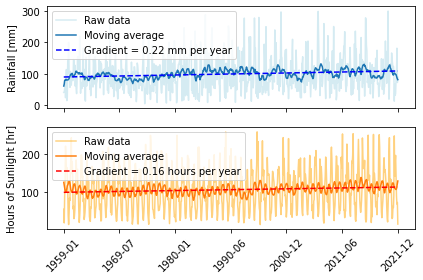

In [ ]:
from matplotlib import pyplot as plt

t = np.array(year_and_month_to_date(df['yyyy'], df['mm']))
yrs2s = 265*24*60*60

fig, axes = plt.subplots(nrows=2, sharex=True)
plt.sca(axes[0])
plt.plot(t, df['rain'], alpha=0.5, color='lightblue', label='Raw data')
plt.plot(t, moving_average(df['rain'], 21), color='C0', label='Moving average')
m, c = np.polyfit(t, df['rain'], 1)
r = np.corrcoef(t, df['rain'])[0, 1]
plt.plot(t, t*m + c, 'b--', label=f'Gradient = {m*yrs2s:.2f} mm per year')
plt.ylabel('Rainfall [mm]')
plt.legend()
pandas
plt.sca(axes[1])
plt.plot(t, df['sun'], alpha=0.5, color='orange', label='Raw data')
plt.plot(t, moving_average(df['sun'], 21), color='C1', label='Moving average')
m, c = np.polyfit(t, df['sun'], 1)
r = np.corrcoef(t, df['sun'])[0, 1]
plt.plot(t, t*m + c, 'r--', label=f'Gradient = {m*yrs2s:.2f} hours per year')
plt.ylabel('Hours of Sunlight [hr]')
plt.legend()

xtickpos = np.linspace(min(t), max(t), 7)
plt.xticks(
    xtickpos,
    [datetime.fromtimestamp(ts).strftime('%Y-%m') for ts in xtickpos],
    rotation=45
)
plt.tight_layout()
plt.show()

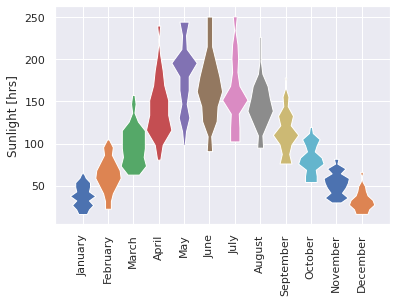

In [ ]:
import calendar

fig, axes = plt.subplots()
for m in range(12):
  sun = df['sun'][df['mm'] == m+1]
  # OR
  # sun = df[df['mm'] == m+1]['sun']
  dist, edges = np.histogram(sun)
  dist = dist / np.max(dist) / 2.
  bins = (edges[:-1]+edges[1:])*0.5
  plt.fill_betweenx(bins, dist+m, -dist+m)

plt.ylabel('Sunlight [hrs]')
plt.xticks(range(12), [calendar.month_name[i+1] for i in range(12)], rotation=90)
plt.show()

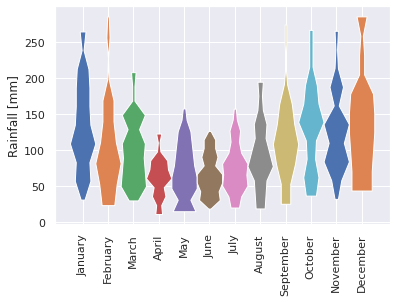

In [ ]:
fig, axes = plt.subplots()
for m in range(12):
  rain = df['rain'][df['mm'] == m+1]
  dist, edges = np.histogram(rain)
  d5 = np.percentile()
  dist = dist / np.max(dist) / 2.
  bins = (edges[:-1]+edges[1:])*0.5
  plt.fill_betweenx(bins,dist+m, -dist+m)

plt.ylabel('Rainfall [mm]')
plt.xticks(range(12), [calendar.month_name[i+1] for i in range(12)], rotation=90)
plt.show()

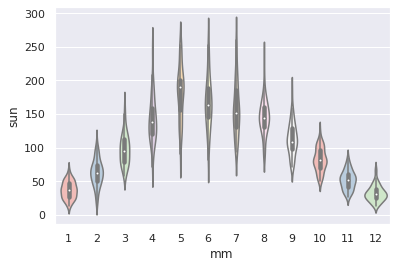

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# Grouped violinplot
sns.violinplot(x="mm", y="sun", data=df, palette="Pastel1")
plt.show()

-0.4930038904789302


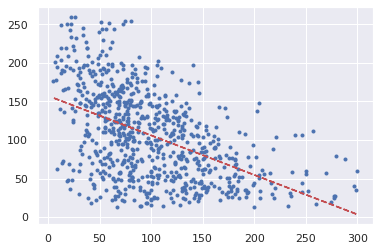

In [ ]:
plt.plot(df['rain'], df['sun'], '.')
cc = np.corrcoef(df['rain'], df['sun'])[0, 1]
print(cc)
m, c = np.polyfit(df['rain'], df['sun'], 1)
plt.plot(df['rain'], np.array(df['rain'])*m + c, 'r--')
plt.show()

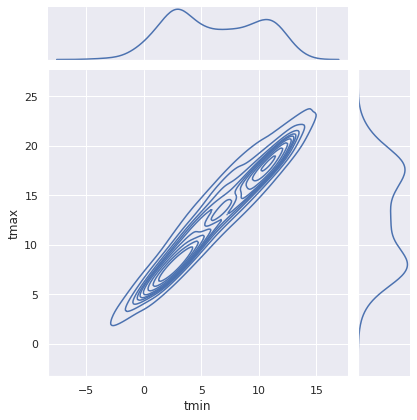

In [ ]:
sns.jointplot(x=df["tmin"], y=df["tmax"], kind='kde')
plt.show()

# How much water do people need?

- https://blog.ferrovial.com/en/2020/03/how-many-litres-of-water-does-a-person-need-per-day/
- https://www.who.int/teams/environment-climate-change-and-health/water-sanitation-and-health/environmental-health-in-emergencies/humanitarian-emergencies

20l per day, at least for drinking, cooking, and hygiene.

# How many people live in and around {this station}?

- Paisley approx pop.: 77k
- Paisley approx area: ??

Or other nearby area:
- Inverclyde approx pop.: 258k
- Inverclyde approx area: 422km^2
(https://archive.ph/20120911075526/http://www.strathclydefire.org/your-area/renfrewshire--inverclyde.aspx)

In [ ]:
n_people = 258_000
area = 422*1000*1000  # m^2
daily_water_per_person = 20  # litres

tot_rainfall_mm = sum(df['rain'])
years = np.array(df['yyyy'])
start_year, end_year = years[[0, -1]]
av_annual_rainfall_mm = tot_rainfall_mm/(end_year - start_year)
print(f'Paisley station reports {tot_rainfall_mm} mm of rainfall in total from {start_year} to {end_year}: on average {av_annual_rainfall_mm:.3f} mm per year.')

required_water_l = n_people * daily_water_per_person * 365  # litres per year
required_collection_area = required_water_l / av_annual_rainfall_mm

max_water_l = av_annual_rainfall_mm * area

print(f'Inverclyde\'s population of {n_people//1000} thousand need {required_water_l*1e-9:.2f} billion litres of water annually (basis of {daily_water_per_person} litres per person per day).')
print(f'Therefore, they would need a reservoir with collection area of at least {required_collection_area*1e-6:.1f} km^2.')

Paisley station reports 75241.3 mm of rainfall in total from 1959 to 2021: on average 1213.569 mm per year.
Inverclyde's population of 258 thousand need 1.88 billion litres of water annually (basis of 20 litres per person per day).
Therefore, they would need a reservoir with collection area of at least 1.6 km^2.


In [ ]:
# violin plot per month

for month in range(1, 13):
  rainfall = df['rain'][df['mm'] == month]
  print(rainfall)

reservoirs in inverclyde provide 18 million cubic metres of water https://en.wikipedia.org/wiki/Loch_Thom